### UPRM Hackathon 2025 - MultiLabel Image Classification using Convolutional Neural Networks

* <b> Author: </b> Jean Han, Hamzah Abdulrazzaq, Edgar Perez
* <b> Date: </b> September 5th, 2025
* <b> Objective: 
UPRM Hackathon 2025 will be focused on exploring the capabilities of Convolutional Neural Networks (CNNs) in tackling complex image classification tasks. Specifically, participants will delve into the realm of MultiLabel, MultiClass image classification using the 'Nasa Geographical Objects' dataset, which comprises a diverse range of geographical features. The dataset includes images of various landscapes, such as islands, mountains, deserts, rivers, lakes, forests, and cities, with some images featuring combinations of these features. The task at hand is to design and optimize CNN architectures to accurately predict the relevant geographical labels for a given image., The challenge lies in developing a robust model that can effectively handle the complexities of MultiLabel, MultiClass classification, requiring meticulous attention to data preprocessing, hyper-parameter tuning, and potentially incorporating techniques such as transfer learning, data augmentation, and ensemble methods. The winning submissions will be evaluated based on their performance, with a key metric being the model's ability to balance precision and recall across multiple labels.
   </b> 
* <b> Dataset License Acknowledgement: Image courtesy of the Earth Science and Remote Sensing Unit, NASA Johnson Space Center


## Table of Contents

- [Background Information: Neural Networks and Multi-Label Classification](#Background-Information:-Neural-Networks-and-Multi-Label-Classification)
- [Importing Necessary Libraries](#Importing-Necessary-Libraries)
- [Configurations + Basic Visualization](#Configurations-+-Basic-Visualization)
- [Dealing with Data Imbalance](#Data-Imbalance)
- [Custom Image Dataset](#Custom-Image-Dataset)
- [Image Augmentation](#Image-Augmentation)
- [Building CNN Architecture](#Building-CNN-Architecture)
- [Model Training](#Model-Training)
- [Visualize Loss and F1](#Visualize-Metrics)
- [Performance Analysis (Where is the model underperforming?)](#Where-is-the-model-underperforming)
- [Performance Analysis (Confusion Matrix)](#Confusion-Matrix)

<!-- ## Background Information: Neural Networks and Multi-Label Classification -->

#### Convolutional Neural Networks:
A convolutional neural network (CNN or ConvNet) is a class of deep neural networks, most commonly applied to analyzing visual imagery. They have proven to be very effective in image and video recognition, recommender systems, image classification, medical image analysis, natural language processing, brain-computer interfaces, and financial time series modeling. CNNs are regularized versions of multilayer perceptrons. Multilayer perceptrons usually mean fully connected networks, that is, each neuron in one layer is connected to all neurons in the next layer. The "fully-connectedness" of these networks makes them prone to overfitting data. Typical ways of regularization include adding some form of magnitude measurement of weights to the loss function. CNNs take a different approach towards regularization: they take advantage of the hierarchical pattern in data and assemble more complex patterns using smaller and simpler patterns. Therefore, on the scale of connectedness and complexity, CNNs are on the lower extreme.Convolutional networks were inspired by biological processes in that the connectivity pattern between neurons resembles the organization of the animal visual cortex. Individual cortical neurons respond to stimuli only in a restricted region of the visual field known as the receptive field. The receptive fields of different neurons partially overlap such that they cover the entire visual field.


#### MultiLabel Classification

In traditional image classification (single-label), each image belongs to exactly one class. However, in multi-label classification, each image can simultaneously belong to multiple classes. For example, an image might contain both a "dog" and a "person" - requiring the model to predict multiple correct labels. This fundamentally changes the classification problem from selecting a single class from mutually exclusive options to making independent binary decisions about the presence of each possible class.

#### Challenges of MultiLabel Classification

1. __Class Imbalance__: Some labels may appear much more frequently than others.
2. __Label Correlations__: Labels often exhibit strong correlations (e.g., "beach" and "ocean" frequently co-occur), which the model needs to learn.
3. __Evaluation Complexity__: Simple accuracy metrics become insufficient; metrics like F1-score, Hamming loss, mean average precision (mAP), or precision-recall curves are more appropriate.
4. __Data Augmentation__: It is critical to ensure diversity of images with Multi-Label tasks. Effective strategies include random crops, flips, rotations, etc. 

#### Helpful Resources:
- [What are Convolutional Neural Networks](https://www.bing.com/videos/search?q=convolutional+neural+network&docid=603549927117705930&mid=E7ED04059A9474B24BFEE7ED04059A9474B24BFE&view=detail&FORM=VIRE)
- [Overview of MultiLabel Classification](https://en.wikipedia.org/wiki/Multi-label_classification)
- [MultiLabel Classification Demo for Beginners](https://medium.com/data-science-in-your-pocket/multi-label-classification-for-beginners-with-codes-6b098cc76f99)
- [Interactive Demo for Image kernels](https://deeplizard.com/resource/pavq7noze2)
- [Introduction to Pooling Layers](https://www.geeksforgeeks.org/deep-learning/cnn-introduction-to-pooling-layer/)

# Download data

In [1]:
!pip install -r requirements.txt
!pip install albumentations

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("olebro/nasa-geographical-objects-multilabel-dataset")

# Importing Necessary Libraries

# Importing Necessary Libraries

In [3]:
import torch   
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import ast
from collections import Counter
from tqdm import tqdm
from torchvision.transforms import transforms
from sklearn.utils import resample
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

In [4]:
import warnings 
warnings.filterwarnings("ignore")

In [5]:
train_data_raw = pd.read_csv('data/train.csv')
val_data_raw = pd.read_csv('data/val.csv')

print(f'Training data shape: {train_data_raw.shape}')
print(f'Validation data shape: {val_data_raw.shape}')

Training data shape: (1248, 3)
Validation data shape: (765, 3)


# Configurations + Basic Visualization

In [6]:
class Config:
    img_dimensions = (128, 128)
    channels = 3
    images_path = os.path.join(path, 'images') # for now
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    learning_rate = 0.0001
    batch_size = 32
    num_epochs = 35

## Class Imbalance Analysis and Visualization

In [7]:
def analyze_label_distribution(data, label_col='Label Vector', string_col='Label String'):
    """
    Comprehensive analysis of label distribution in multi-label dataset
    """
    # Parse label vectors
    label_vectors = []
    for label_str in data[label_col]:
        label_vec = ast.literal_eval(label_str)
        label_vectors.append(label_vec)
    
    label_vectors = np.array(label_vectors)
    
    # Get unique label combinations and their counts
    unique_combinations = {}
    for i, row in data.iterrows():
        label_combo = row[string_col]
        if label_combo in unique_combinations:
            unique_combinations[label_combo] += 1
        else:
            unique_combinations[label_combo] = 1
    
    # Individual label frequencies
    individual_labels = ['BEACH', 'CITY', 'COAST', 'DESERT', 'FOREST', 'ISLAND', 'LAKE', 'MOUNTAIN', 'RIVER', 'SNOW']
    label_counts = np.sum(label_vectors, axis=0)
    
    print("=== INDIVIDUAL LABEL DISTRIBUTION ===")
    for i, (label, count) in enumerate(zip(individual_labels, label_counts)):
        percentage = (count / len(data)) * 100
        print(f"{label}: {count} samples ({percentage:.2f}%)")
    
    print("\n=== LABEL COMBINATION DISTRIBUTION ===")
    sorted_combinations = sorted(unique_combinations.items(), key=lambda x: x[1], reverse=True)
    for combo, count in sorted_combinations[:15]:  # Top 15 combinations
        percentage = (count / len(data)) * 100
        print(f"{combo}: {count} samples ({percentage:.2f}%)")
    
    print(f"\nTotal unique label combinations: {len(unique_combinations)}")
    
    return label_vectors, unique_combinations, label_counts, individual_labels

def visualize_class_imbalance(label_counts, individual_labels, unique_combinations):
    """
    Create visualizations for class imbalance
    """
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))
    
    # Individual label distribution
    axes[0, 0].bar(individual_labels, label_counts, color='skyblue', edgecolor='navy')
    axes[0, 0].set_title('Individual Label Distribution', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Labels')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Label combination distribution (top 20)
    sorted_combinations = sorted(unique_combinations.items(), key=lambda x: x[1], reverse=True)[:20]
    combo_names = [combo[0] for combo in sorted_combinations]
    combo_counts = [combo[1] for combo in sorted_combinations]
    
    axes[0, 1].bar(range(len(combo_names)), combo_counts, color='lightcoral', edgecolor='darkred')
    axes[0, 1].set_title('Top 20 Label Combinations Distribution', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Label Combinations')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_xticks(range(len(combo_names)))
    axes[0, 1].set_xticklabels(combo_names, rotation=45, ha='right')
    
    # Imbalance ratio visualization
    max_count = max(label_counts)
    imbalance_ratios = max_count / label_counts
    axes[1, 0].bar(individual_labels, imbalance_ratios, color='orange', edgecolor='darkorange')
    axes[1, 0].set_title('Class Imbalance Ratio (Max/Current)', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Labels')
    axes[1, 0].set_ylabel('Imbalance Ratio')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # Label co-occurrence heatmap
    cooccurrence_matrix = np.zeros((len(individual_labels), len(individual_labels)))
    
    for combo_str, count in unique_combinations.items():
        # Parse which labels are present
        labels_present = []
        for i, label in enumerate(individual_labels):
            if label in combo_str:
                labels_present.append(i)
        
        # Update co-occurrence matrix
        for i in labels_present:
            for j in labels_present:
                cooccurrence_matrix[i, j] += count
    
    sns.heatmap(cooccurrence_matrix, 
                xticklabels=individual_labels, 
                yticklabels=individual_labels,
                annot=True, fmt='.0f', cmap='Blues', ax=axes[1, 1])
    axes[1, 1].set_title('Label Co-occurrence Matrix', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return cooccurrence_matrix

def calculate_imbalance_metrics(label_counts):
    """
    Calculate various imbalance metrics
    """
    total_samples = np.sum(label_counts)
    
    # Imbalance Ratio (IR)
    max_class = np.max(label_counts)
    min_class = np.min(label_counts)
    imbalance_ratio = max_class / min_class
    
    # Mean Per Label (MPL)
    mean_per_label = np.mean(label_counts)
    
    # Label Cardinality (average number of labels per instance)
    # This will be calculated later when we have the full dataset
    
    # Coefficient of Variation
    cv = np.std(label_counts) / np.mean(label_counts)
    
    print("=== IMBALANCE METRICS ===")
    print(f"Imbalance Ratio (Max/Min): {imbalance_ratio:.2f}")
    print(f"Mean Per Label: {mean_per_label:.2f}")
    print(f"Coefficient of Variation: {cv:.3f}")
    print(f"Most frequent class: {max_class} samples")
    print(f"Least frequent class: {min_class} samples")
    
    return {
        'imbalance_ratio': imbalance_ratio,
        'mean_per_label': mean_per_label,
        'coefficient_variation': cv,
        'max_class_count': max_class,
        'min_class_count': min_class
    }

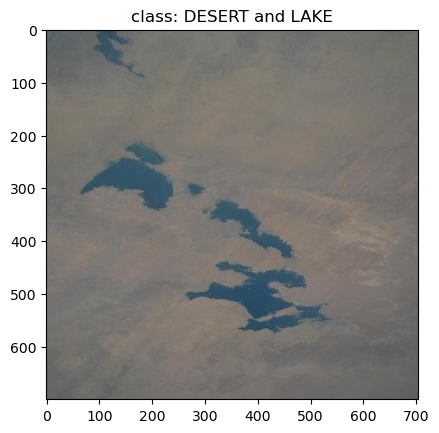

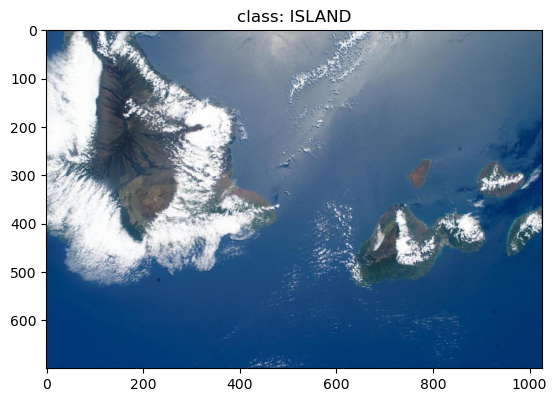

In [8]:
def img_display(path, label):
    img = cv2.imread(path)[:,:,::-1]
    plt.imshow(img)
    plt.grid(False)
    plt.title(f'class: {label}')
    plt.show()

train_imgs = [os.path.join(Config.images_path, img) for img in train_data_raw['FileName']]
train_labels = [lbl for lbl in train_data_raw['Label Vector']]
train_string_labels = [lbl for lbl in train_data_raw['Label String']]

val_imgs = [os.path.join(Config.images_path, img) for img in val_data_raw['FileName']]
val_labels = [lbl for lbl in val_data_raw['Label Vector']]
val_string_labels = [lbl for lbl in val_data_raw['Label String']]

img_display(train_imgs[0], train_string_labels[0])
img_display(val_imgs[0], val_string_labels[0])

TRAINING DATA ANALYSIS
=== INDIVIDUAL LABEL DISTRIBUTION ===
BEACH: 85 samples (6.81%)
CITY: 64 samples (5.13%)
COAST: 140 samples (11.22%)
DESERT: 436 samples (34.94%)
FOREST: 4 samples (0.32%)
ISLAND: 333 samples (26.68%)
LAKE: 152 samples (12.18%)
MOUNTAIN: 212 samples (16.99%)
RIVER: 193 samples (15.46%)
SNOW: 246 samples (19.71%)

=== LABEL COMBINATION DISTRIBUTION ===
ISLAND: 261 samples (20.91%)
MOUNTAIN and SNOW: 182 samples (14.58%)
DESERT: 173 samples (13.86%)
DESERT and LAKE: 107 samples (8.57%)
RIVER: 99 samples (7.93%)
COAST and ISLAND: 72 samples (5.77%)
COAST and DESERT: 68 samples (5.45%)
AGRICULTURE and DESERT: 54 samples (4.33%)
CITY and RIVER: 54 samples (4.33%)
LAKE and SNOW: 40 samples (3.21%)
DESERT and RIVER: 34 samples (2.72%)
AGRICULTURE: 31 samples (2.48%)
SNOW: 24 samples (1.92%)
MOUNTAIN: 24 samples (1.92%)
CITY: 10 samples (0.80%)

Total unique label combinations: 18
=== IMBALANCE METRICS ===
Imbalance Ratio (Max/Min): 109.00
Mean Per Label: 186.50
Coeffici

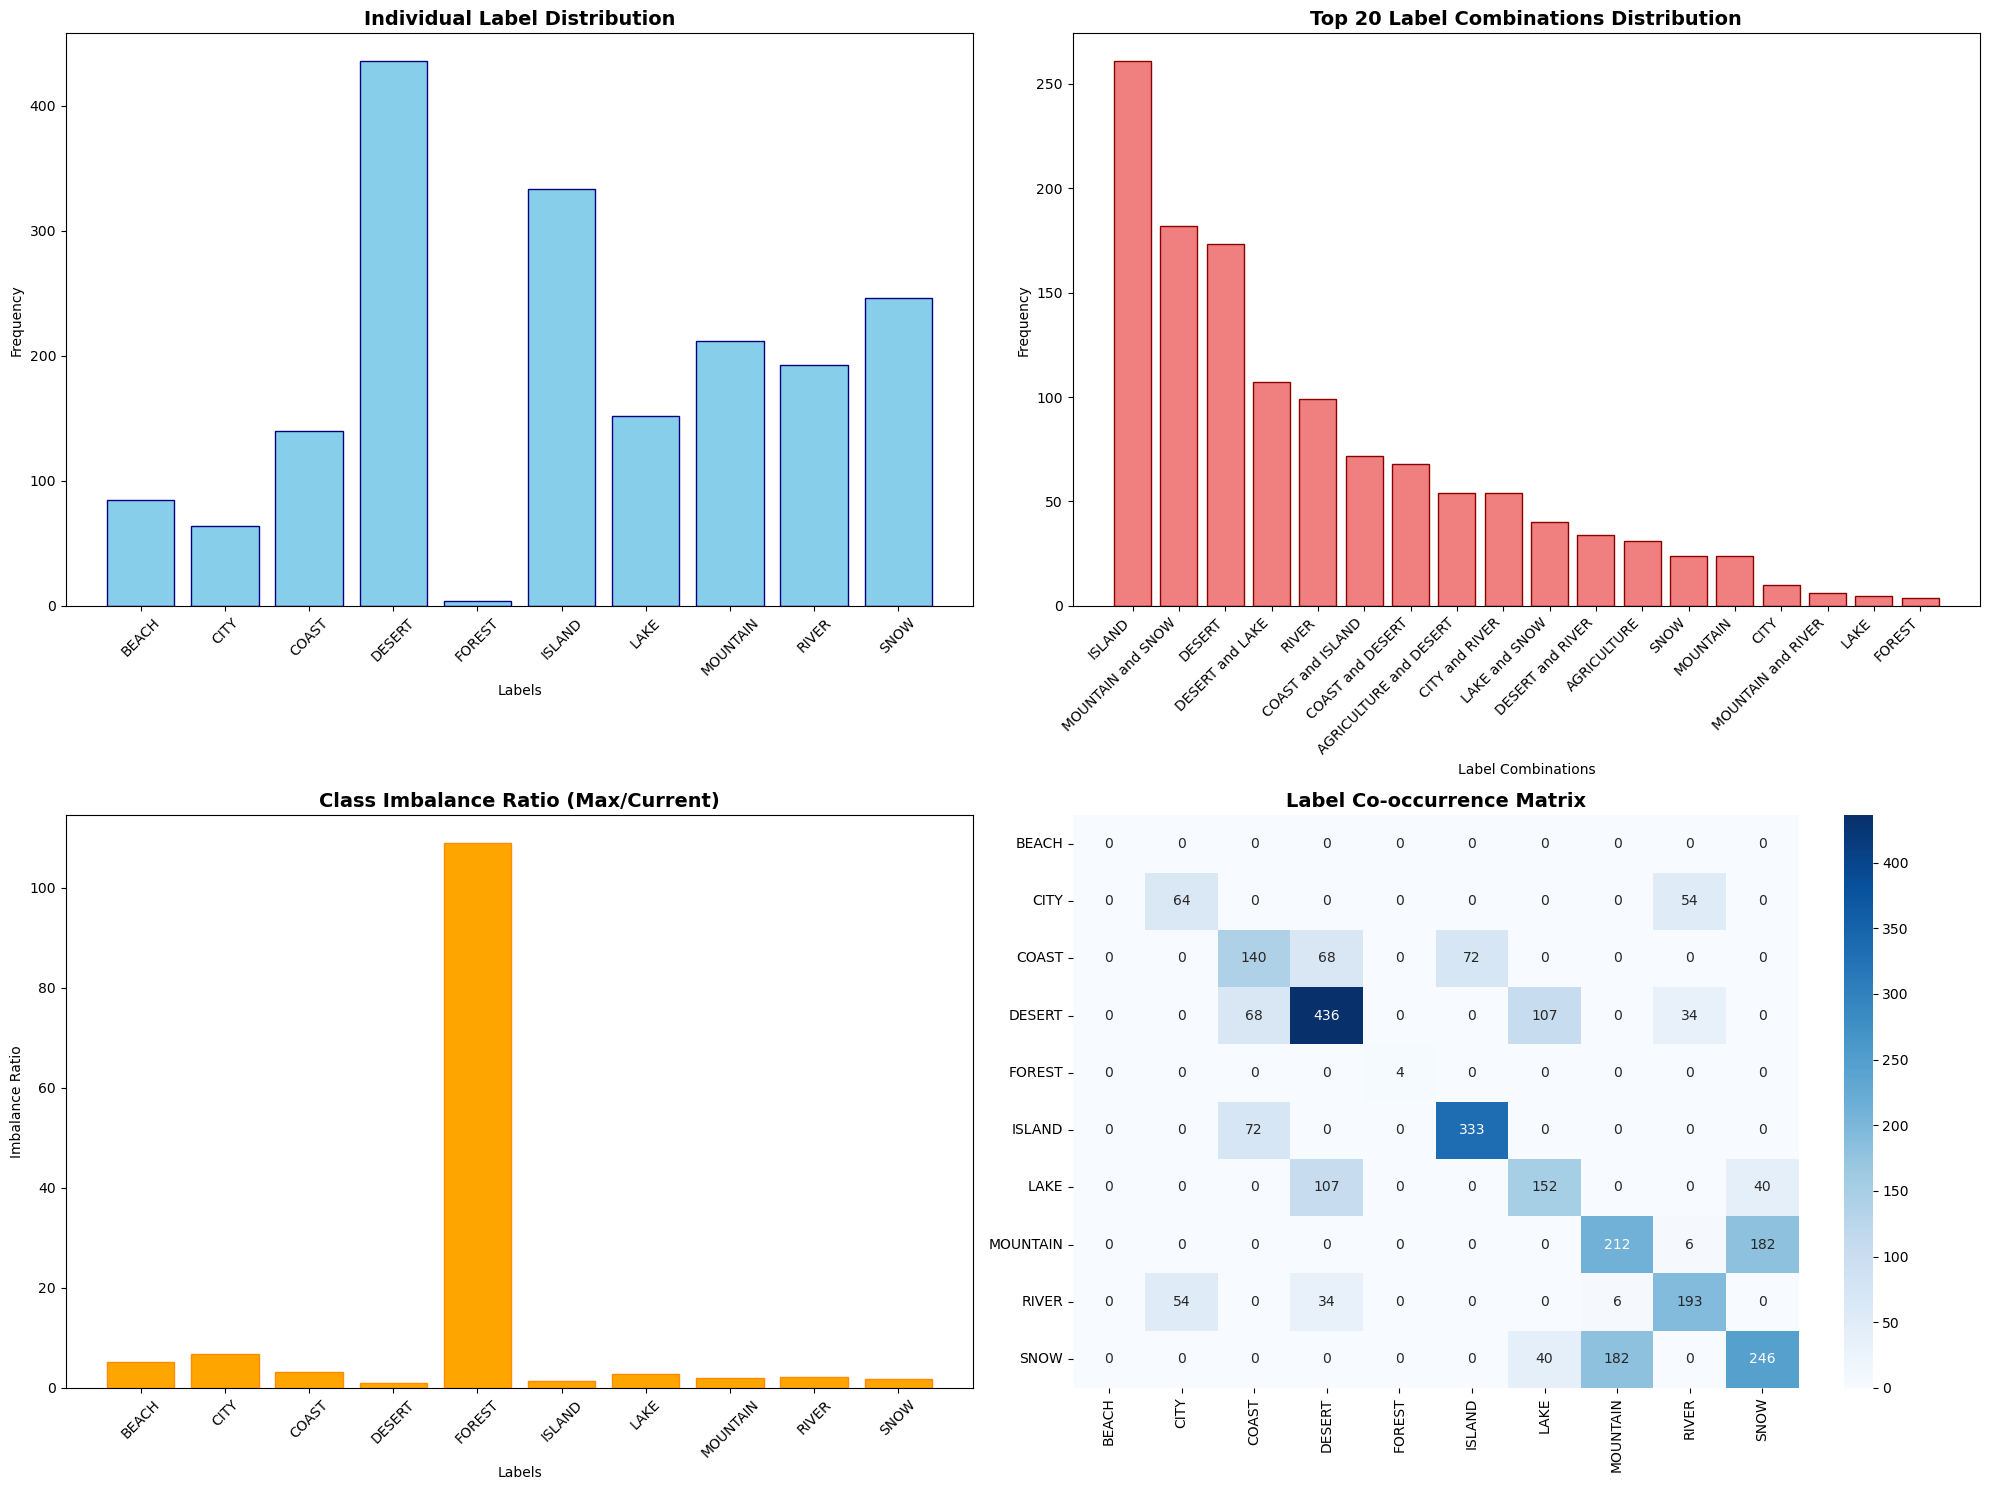

In [9]:
# Analyze class imbalance in training data
print("TRAINING DATA ANALYSIS")
print("=" * 50)
train_label_vectors, train_combinations, train_label_counts, individual_labels = analyze_label_distribution(train_data_raw)
train_metrics = calculate_imbalance_metrics(train_label_counts)

print("\n\nVALIDATION DATA ANALYSIS")
print("=" * 50)
val_label_vectors, val_combinations, val_label_counts, _ = analyze_label_distribution(val_data_raw)
val_metrics = calculate_imbalance_metrics(val_label_counts)

# Visualize the imbalance
print("\n\nVISUALIZING TRAINING DATA IMBALANCE...")
cooccurrence_matrix = visualize_class_imbalance(train_label_counts, individual_labels, train_combinations)

In [10]:
class WeightedBCEWithLogitsLoss(nn.Module):
    """
    Weighted Binary Cross Entropy Loss to handle class imbalance
    """
    def __init__(self, pos_weights=None):
        super(WeightedBCEWithLogitsLoss, self).__init__()
        self.pos_weights = pos_weights
        
    def forward(self, inputs, targets):
        if self.pos_weights is not None:
            loss = F.binary_cross_entropy_with_logits(
                inputs, targets, pos_weight=self.pos_weights
            )
        else:
            loss = F.binary_cross_entropy_with_logits(inputs, targets)
        return loss

def calculate_pos_weights(label_counts, strategy='inverse_freq'):
    """
    Calculate positive weights for weighted loss
    """
    total_samples = len(train_data_raw)
    
    if strategy == 'inverse_freq':
        # Inverse frequency weighting
        pos_weights = total_samples / (2 * label_counts)
    elif strategy == 'effective_num':
        # Effective number of samples weighting
        beta = 0.9999
        effective_num = 1.0 - np.power(beta, label_counts)
        pos_weights = (1.0 - beta) / effective_num
    else:
        # Balanced weighting
        neg_counts = total_samples - label_counts
        pos_weights = neg_counts / label_counts
    
    return torch.FloatTensor(pos_weights)

# Calculate positive weights for the loss function
pos_weights = calculate_pos_weights(train_label_counts, strategy='inverse_freq')
print("\nCalculated positive weights for each class:")
for i, (label, weight) in enumerate(zip(individual_labels, pos_weights)):
    print(f"{label}: {weight:.3f}")

# Create weighted loss function
weighted_criterion = WeightedBCEWithLogitsLoss(pos_weights=pos_weights.to(Config.device) if torch.cuda.is_available() else pos_weights)


Calculated positive weights for each class:
BEACH: 7.341
CITY: 9.750
COAST: 4.457
DESERT: 1.431
FOREST: 156.000
ISLAND: 1.874
LAKE: 4.105
MOUNTAIN: 2.943
RIVER: 3.233
SNOW: 2.537


## Data Imbalance
Data imbalance in multilabel classification presents a distinct challenge that differs from binary or multiclass settings. This imbalance occurs in two distinct forms: label-level imbalance and label-combination imbalance. Label-level imbalance arises when certain individual labels appear significantly less frequently than others. In contrast, label-combination imbalance occurs when specific combinations of labels co-occur rarely, making it difficult for models to learn effective representations for these infrequent label combinations.

We recommend reading through [Handling Data Imbalance for MultiLabel Classification](https://medium.com/thecyphy/handling-data-imbalance-in-multi-label-classification-mlsmote-531155416b87). This is a great way to get started. Another great way to handle data imbalance is by using [Focal Loss](https://docs.pytorch.org/vision/main/generated/torchvision.ops.sigmoid_focal_loss.html). 

There are many different strategies that can be implemented to solve this issue. We recommend experimenting with different options and seeing which ones provide the most promising results. 

## Helper Functions

In [11]:
def resize_normalize(img):
    """
    Argument: image
    steps: 1. Resize image to specified dimensions
           2. transpose so that channels are first
           3. resize image
    """
    img = cv2.resize(img, Config.img_dimensions)
    
    #ret,img = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
    img = np.transpose(img, (2,0,1)) # reorder it to channels first
    img = torch.from_numpy(img).float()
    img = img / 255
    
    return img
    
def to_numpy(x):
    return x.detach().cpu().numpy()

## Custom Image Dataset

A PyTorch Custom Image Dataset is a class that inherits from PyTorch's Dataset class which provides a way to create a dataset that is tailored to your requirements and needs. It integrates efficiently with PyTorch's DataLoader, allowing us to load and process images in batches during model training and validation

#### What is it used for?
- Data Loading: Standardized way to load images and labels from disk.
- Data Preprocessing: Consistent application of transformations (resizing, augmentation, etc.) to images.
- Batch Creation: Mini-batch generation for training.
- Memory Efficiency: Load images only when needed rather than storing entire dataset in memory. 

Provided below is a custom image dataset that you may use for this challenge. You may add your own modifications by reading through [PyTorch's documentation](https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html). 

In [12]:
class CustomImageDataset(Dataset):
    def __init__(self, dataset, img_dir, transform=None, target_transform=None, use_albumentations=False):
        self.dataset = dataset
        self.image_labels = list(dataset['Label Vector'])
        self.image_path = list(dataset['FileName'])
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.use_albumentations = use_albumentations
        
    def __len__(self):
        return len(self.dataset)
        
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.dataset.loc[idx, 'FileName'])
        image = cv2.imread(img_path)
        label = self.dataset.loc[idx, 'Label Vector']
        
        if self.use_albumentations and self.transform:
            # For Albumentations, convert BGR to RGB and pass as numpy array
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            # Apply Albumentations transforms directly
            image = self.transform(image)
        else:
            # Use the original resize_normalize function for torchvision transforms
            image = resize_normalize(image)
            if self.transform:
                image = self.transform(image)
        
        # Convert the label vector to a tensor
        label = torch.tensor(eval(label))
        
        if self.target_transform:
            label = self.target_transform(label)
            
        return image, label

### Image Augmentation

Image augmentation is an absolutely wonderful way to artificially expand your training dataset, which is especially valuable when working with limited data — a common constraint in real-world image tasks. By creating variations of existing images through transformations like rotations, flips, zooms, and crops, you essentially teach your CNN to recognize objects under different viewing conditions without collecting additional data.

More fundamentally, augmentation directly addresses overfitting by preventing the network from memorizing exact pixel patterns. When a CNN sees the same exact images repeatedly, it tends to learn specific pixel configurations rather than generalizable features. By presenting slightly different versions each time, you force the network to learn robust representations that capture the essence of objects rather than superficial details.

Augmentation also introduces invariance properties into your model. For classification tasks, whether an image is slightly rotated, zoomed, or shifted shouldn't change the label. By training with these variations, your CNN develops translation, rotation, and scale invariance—crucial properties for real-world deployment where objects rarely appear in perfectly consistent positions or orientations.

The CustomImageDataset created above is setup to handle image transforms. A blank example is provided below. See documentation [here](https://docs.pytorch.org/vision/stable/transforms.html?highlight=compose)


In [14]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np

class AlbumentationsTransform:
    def __init__(self, aug):
        self.aug = aug

    def __call__(self, image):
        # Albumentations expects numpy array in (H, W, C) format with RGB color order
        # Image should already be in correct format from dataset
        augmented = self.aug(image=image)
        return augmented['image']


In [15]:
# Define comprehensive training augmentations with Albumentations
training_augmentations = AlbumentationsTransform(
    A.Compose([
        # Geometric transformations
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.3),
        A.RandomRotate90(p=0.3),
        A.SafeRotate(limit=15, p=0.5),
        # A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=15, p=0.5),
        
        # Perspective and distortion
        # A.OpticalDistortion(p=0.3),
        # A.GridDistortion(p=0.3),
        # A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.3),
        
        # Color augmentations
        # A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
        # A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
        # A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        # A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.3),
        
        # Noise and blur effects
        # A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
        A.Blur(blur_limit=2, p=0.2),
        # A.MotionBlur(blur_limit=3, p=0.2),
        # A.GaussianBlur(blur_limit=3, p=0.2),
        
        # Weather effects (relevant for geographical features)
        # A.RandomFog(fog_coef_lower=0.1, fog_coef_upper=0.3, alpha_coef=0.08, p=0.2),
        # A.RandomSunFlare(flare_roi=(0, 0, 1, 0.5), angle_lower=0, angle_upper=1, 
                        # num_flare_circles_lower=6, num_flare_circles_upper=10, 
                        # src_radius=160, p=0.2),
        # A.RandomShadow(shadow_roi=(0, 0.5, 1, 1), num_shadows_lower=1, 
        #               num_shadows_upper=2, shadow_dimension=5, p=0.2),
        
        # Cropping and resizing
        # A.RandomResizedCrop(size=Config.img_dimensions, 
        #                    scale=(0.8, 1.0), ratio=(0.75, 1.33), p=0.5),
        # A.CenterCrop(height=Config.img_dimensions[0], width=Config.img_dimensions[1], p=0.2),
        
        # Ensure final size and normalize
        A.Resize(height=Config.img_dimensions[0], width=Config.img_dimensions[1]),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
)

# Define validation transforms (no augmentations, just resize and normalize)
validation_transforms = AlbumentationsTransform(
    A.Compose([
        A.Resize(height=Config.img_dimensions[0], width=Config.img_dimensions[1]),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
)


In [16]:
# Use Albumentations for training with comprehensive augmentations
train_ds = CustomImageDataset(
    train_data_raw, 
    Config.images_path, 
    transform=training_augmentations, 
    use_albumentations=True
)

# Use Albumentations for validation with minimal processing
valid_ds = CustomImageDataset(
    val_data_raw, 
    Config.images_path, 
    transform=validation_transforms, 
    use_albumentations=True
)

print(f"Training dataset size: {len(train_ds)}")
print(f"Validation dataset size: {len(valid_ds)}")
print("Datasets created with Albumentations transforms!")

# Test a single sample to verify transforms work
try:
    sample_img, sample_label = train_ds[0]
    print(f"Sample image shape: {sample_img.shape}")
    print(f"Sample label shape: {sample_label.shape}")
    print("✓ Albumentations transforms working correctly!")
except Exception as e:
    print(f"Error with transforms: {e}")

Training dataset size: 1248
Validation dataset size: 765
Datasets created with Albumentations transforms!
Sample image shape: torch.Size([3, 128, 128])
Sample label shape: torch.Size([10])
✓ Albumentations transforms working correctly!


Visualizing Albumentations augmented training images:


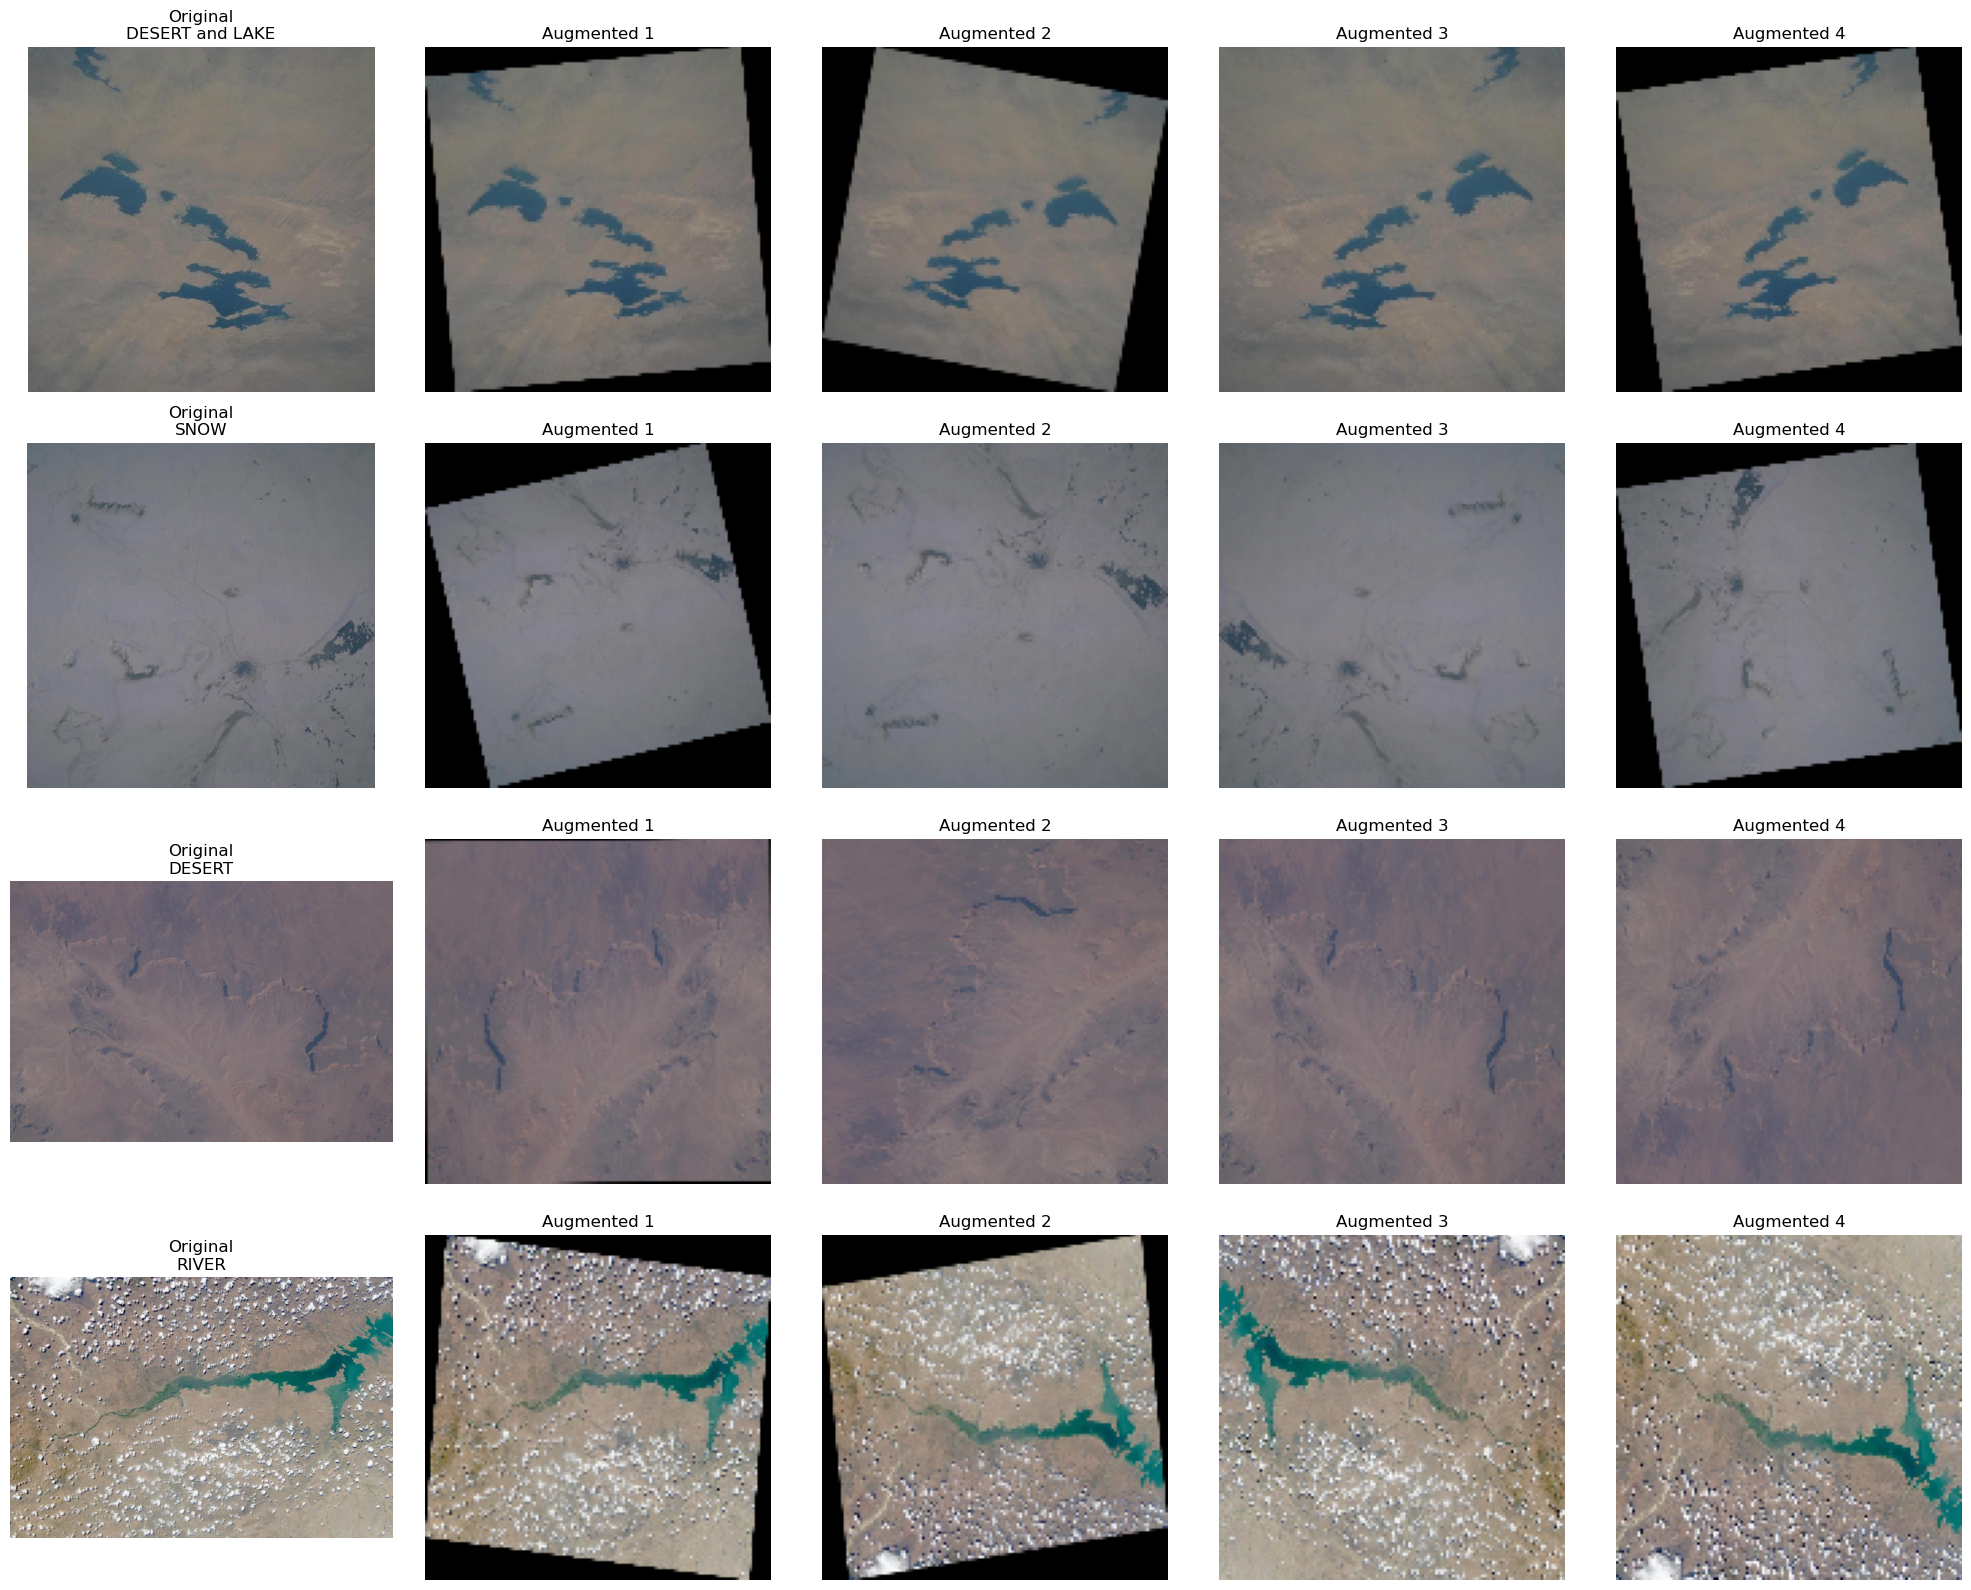

In [17]:
# Function to visualize augmented images
def visualize_augmentations(dataset, num_samples=4, augmentations_per_image=4):
    """
    Visualize original images alongside their augmented versions
    """
    fig, axes = plt.subplots(num_samples, augmentations_per_image + 1, figsize=(20, 4*num_samples))
    
    for i in range(num_samples):
        # Get original image
        img_path = os.path.join(Config.images_path, dataset.dataset.iloc[i]['FileName'])
        original_img = cv2.imread(img_path)
        original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
        
        # Show original image
        axes[i, 0].imshow(original_img)
        axes[i, 0].set_title(f'Original\n{dataset.dataset.iloc[i]["Label String"]}')
        axes[i, 0].axis('off')
        
        # Show augmented versions
        for j in range(augmentations_per_image):
            augmented_img, _ = dataset[i]  # Get augmented image
            
            # Convert tensor back to displayable format
            if torch.is_tensor(augmented_img):
                # Denormalize using ImageNet stats
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                
                img_display = augmented_img.permute(1, 2, 0).numpy()
                img_display = img_display * std + mean
                img_display = np.clip(img_display, 0, 1)
            else:
                img_display = augmented_img
            
            axes[i, j+1].imshow(img_display)
            axes[i, j+1].set_title(f'Augmented {j+1}')
            axes[i, j+1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize some augmented training images
print("Visualizing Albumentations augmented training images:")
visualize_augmentations(train_ds, num_samples=4, augmentations_per_image=4)

### CNN Model Architecture

There are two ways to approaching the model architecture phase of the problem. 

1. Building your own CNN architecture. An example is provided below where modifications can be made. 
2. Using pretrained models.

### Building Your Own CNN Architecture

__Advantages:__

- Complete control over the architecture design. 
- Freedom to experiment with novel layer arrangements, activation functions, and skip connections.
- No constraints from pretrained weights or architectures that may not be optimal for your domain.
- Typically results in a smaller, more compute efficient model since you only include what you need.

__Disadvantages:__

- Requires a bit more expertise and understanding of Neural Network design
- More epochs are needed as learning must start from random initialization
- Needs much more data to achieve good performance (often prohibitively large amounts)
- Higher risk of overfitting, especially with limited data

### Using Pretrained Models

__Advantages:__

- Leverage powerful feature extractors trained on massive datasets (like ImageNet with 1.2M images)
- Dramatically reduced training time and computational requirements (though more compute resources are needed to get started)
- Excellent performance even with limited domain-specific data
- Built-in robustness against common image variations and noise
- Access to state-of-the-art architectures (ResNet, EfficientNet, Vision Transformers) without designing them

__Disadvantages:__

- Less control over the underlying architecture
- May include unnecessary complexity for simpler tasks
- Domain shift can be problematic if your images differ significantly from pretraining data
- Fixed input requirements (resolution, channels) that may require preprocessing



In [18]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=10):
        super(CNNModel, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(16384, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
        
    def forward(self, x):
        # Convolutional layers with ReLU activation and batch normalization
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool3(x)

        # Flatten the output
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [19]:
from timm import create_model
from huggingface_hub import hf_hub_download

# Download pretrained weights (pytorch_model.bin) from HuggingFace
ckpt_path = hf_hub_download(repo_id="cm93/resnet50-eurosat", filename="pytorch_model.bin")
# Initialize ResNet-50 for 10 classes
pt_model = create_model('resnet50', pretrained=False, num_classes=10)
pt_model.load_state_dict(torch.load(ckpt_path, map_location=torch.device('cuda')))

print("Model successfully loaded on GPU")

Model successfully loaded on GPU


## Model Training

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
def train_model(
    model, train_ds, valid_ds, epochs, learning_rate, num_classes, version
):
    os.makedirs('model_checkpoints/', exist_ok=True)
    torch.manual_seed(39) # set seed
    #model = torch.nn.DataParallel(model)
    model = model.to(Config.device)
    model_name = model.__class__.__name__# instantiate model
    print(model) # print model architecture
    workers = min(os.cpu_count() - 1, 4)
    train_dataloader = DataLoader(
        train_ds, batch_size=Config.batch_size, shuffle=True, num_workers = workers, prefetch_factor = 6,  
        pin_memory=False
    ) # this will allow us to iterate through images in batches
    test_dataloader = DataLoader(
        valid_ds, batch_size=Config.batch_size, shuffle=False, num_workers = workers, prefetch_factor = 6,  
        pin_memory=False
    )
    criterion = nn.BCEWithLogitsLoss()

    # value of 0 would denote perfect model. It is also a measure of class purity. 
    optimizer = torch.optim.Adam(
        model.parameters(), lr=learning_rate, weight_decay=1e-4
    ) # In short, optimizer is used to minimize loss. We are using Adam since it tends
    # to have smaller variance and faster convergence.
    f1_hist_train = []
    f1_hist_val = []
    
    train_losses = []
    val_losses = []
    
    
    for epoch in range(1, epochs + 1): # loop over dataset many times
        model.train()  # set to train mode
        running_loss = 0.0
        accuracy_hist_train = 0.0
        running_f1_train = 0.0
        for x_batch, y_batch in tqdm(train_dataloader):
            x_batch = x_batch.to(Config.device)
            y_batch = y_batch.to(Config.device)
            pred = model(x_batch)
            loss = criterion(pred, y_batch.float())
            loss.backward() # back propoagation
            optimizer.step() # updates weights
            optimizer.zero_grad() # zero out the gradients 
            running_loss += loss.item()
            pred = torch.sigmoid(pred)
            f1_cal = f1_score((to_numpy(pred) > 0.5), to_numpy(y_batch), average='micro')

            # how many of predictions were correct?
            running_f1_train += f1_cal

        running_f1_train /= np.ceil(len(train_dataloader.dataset)/Config.batch_size)
        running_loss /= len(train_dataloader.dataset)
        # since we accu
        f1_hist_train.append(running_f1_train)
        train_losses.append(running_loss)


        model.eval() # disables dropout, etc
        with torch.no_grad(): # disables gradient 
            val_loss = 0.0
            running_f1_score = 0.0
            for x, y in tqdm(test_dataloader):
                x = x.to(Config.device)
                y = y.to(Config.device)
                pred = model(x) # predict 
                loss = criterion(pred, y.float())
                val_loss += loss
                pred = torch.sigmoid(pred)
                f1_score_calc = f1_score((to_numpy(pred) > 0.5), to_numpy(y), average='micro')
                running_f1_score += f1_score_calc
            val_loss /= len(test_dataloader.dataset)
            running_f1_score /= np.ceil(len(test_dataloader.dataset)/Config.batch_size)


        if (epoch > 1 and val_loss < np.min(val_losses)) or epoch == 1:
            torch.save(model.state_dict(), f'model_checkpoints/checkpoint_{version}_{model_name}.pt')
        
        val_losses.append(to_numpy(val_loss))
        f1_hist_val.append(running_f1_score)
        print(f"Epoch: {epoch}")
        print("Train Loss: \t{:.3f}".format(running_loss))
        print("Val Loss: \t{:.3f}".format(val_loss))
        print("Train F1: \t{:.3f}".format(running_f1_train))
        print("Val F1 Score: \t{:.3f}".format(running_f1_score))
        print("---------------------------------------------")
        

    model.load_state_dict(torch.load(f'model_checkpoints/checkpoint_{version}_{model_name}.pt'))
    # model.eval()

    return model, f1_hist_train, f1_hist_val, train_losses, val_losses

In [21]:
model, f1_hist_train, f1_hist_val, train_losses, val_losses = train_model(pt_model, train_ds, valid_ds, Config.num_epochs, learning_rate=Config.learning_rate, num_classes=10, version=1)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

100%|██████████| 24/24 [00:00<00:00, 25.60it/s]


Epoch: 1
Train Loss: 	0.016
Val Loss: 	0.013
Train F1: 	0.246
Val F1 Score: 	0.311
---------------------------------------------


100%|██████████| 24/24 [00:00<00:00, 25.01it/s]


Epoch: 2
Train Loss: 	0.012
Val Loss: 	0.010
Train F1: 	0.355
Val F1 Score: 	0.445
---------------------------------------------


100%|██████████| 24/24 [00:00<00:00, 25.88it/s]


Epoch: 3
Train Loss: 	0.010
Val Loss: 	0.009
Train F1: 	0.466
Val F1 Score: 	0.524
---------------------------------------------


100%|██████████| 24/24 [00:00<00:00, 25.21it/s]


Epoch: 4
Train Loss: 	0.008
Val Loss: 	0.008
Train F1: 	0.540
Val F1 Score: 	0.598
---------------------------------------------


100%|██████████| 24/24 [00:00<00:00, 24.80it/s]


Epoch: 5
Train Loss: 	0.008
Val Loss: 	0.007
Train F1: 	0.604
Val F1 Score: 	0.675
---------------------------------------------


100%|██████████| 24/24 [00:00<00:00, 25.29it/s]


Epoch: 6
Train Loss: 	0.007
Val Loss: 	0.006
Train F1: 	0.674
Val F1 Score: 	0.721
---------------------------------------------


100%|██████████| 24/24 [00:00<00:00, 25.27it/s]


Epoch: 7
Train Loss: 	0.006
Val Loss: 	0.005
Train F1: 	0.715
Val F1 Score: 	0.758
---------------------------------------------


100%|██████████| 24/24 [00:00<00:00, 25.05it/s]


Epoch: 8
Train Loss: 	0.005
Val Loss: 	0.005
Train F1: 	0.737
Val F1 Score: 	0.783
---------------------------------------------


100%|██████████| 24/24 [00:00<00:00, 25.31it/s]


Epoch: 9
Train Loss: 	0.005
Val Loss: 	0.005
Train F1: 	0.781
Val F1 Score: 	0.791
---------------------------------------------


100%|██████████| 24/24 [00:00<00:00, 25.33it/s]


Epoch: 10
Train Loss: 	0.005
Val Loss: 	0.004
Train F1: 	0.793
Val F1 Score: 	0.817
---------------------------------------------


100%|██████████| 24/24 [00:00<00:00, 25.20it/s]


Epoch: 11
Train Loss: 	0.004
Val Loss: 	0.004
Train F1: 	0.814
Val F1 Score: 	0.826
---------------------------------------------


100%|██████████| 24/24 [00:00<00:00, 25.21it/s]


Epoch: 12
Train Loss: 	0.004
Val Loss: 	0.004
Train F1: 	0.833
Val F1 Score: 	0.839
---------------------------------------------


100%|██████████| 24/24 [00:00<00:00, 25.71it/s]


Epoch: 13
Train Loss: 	0.004
Val Loss: 	0.004
Train F1: 	0.840
Val F1 Score: 	0.845
---------------------------------------------


100%|██████████| 24/24 [00:00<00:00, 25.52it/s]


Epoch: 14
Train Loss: 	0.004
Val Loss: 	0.003
Train F1: 	0.848
Val F1 Score: 	0.861
---------------------------------------------


100%|██████████| 24/24 [00:00<00:00, 25.27it/s]


Epoch: 15
Train Loss: 	0.003
Val Loss: 	0.003
Train F1: 	0.857
Val F1 Score: 	0.861
---------------------------------------------


100%|██████████| 24/24 [00:00<00:00, 26.03it/s]


Epoch: 16
Train Loss: 	0.003
Val Loss: 	0.003
Train F1: 	0.860
Val F1 Score: 	0.873
---------------------------------------------


100%|██████████| 24/24 [00:00<00:00, 25.81it/s]


Epoch: 17
Train Loss: 	0.003
Val Loss: 	0.003
Train F1: 	0.873
Val F1 Score: 	0.872
---------------------------------------------


100%|██████████| 24/24 [00:00<00:00, 25.32it/s]


Epoch: 18
Train Loss: 	0.003
Val Loss: 	0.003
Train F1: 	0.887
Val F1 Score: 	0.879
---------------------------------------------


100%|██████████| 24/24 [00:00<00:00, 25.78it/s]


Epoch: 19
Train Loss: 	0.003
Val Loss: 	0.003
Train F1: 	0.876
Val F1 Score: 	0.878
---------------------------------------------


100%|██████████| 24/24 [00:00<00:00, 25.14it/s]


Epoch: 20
Train Loss: 	0.003
Val Loss: 	0.003
Train F1: 	0.894
Val F1 Score: 	0.884
---------------------------------------------


100%|██████████| 24/24 [00:00<00:00, 24.81it/s]


Epoch: 21
Train Loss: 	0.003
Val Loss: 	0.003
Train F1: 	0.893
Val F1 Score: 	0.881
---------------------------------------------


100%|██████████| 24/24 [00:00<00:00, 25.36it/s]


Epoch: 22
Train Loss: 	0.002
Val Loss: 	0.003
Train F1: 	0.904
Val F1 Score: 	0.886
---------------------------------------------


100%|██████████| 24/24 [00:00<00:00, 25.37it/s]


Epoch: 23
Train Loss: 	0.002
Val Loss: 	0.003
Train F1: 	0.906
Val F1 Score: 	0.891
---------------------------------------------


100%|██████████| 24/24 [00:00<00:00, 25.17it/s]


Epoch: 24
Train Loss: 	0.002
Val Loss: 	0.003
Train F1: 	0.909
Val F1 Score: 	0.897
---------------------------------------------


100%|██████████| 24/24 [00:00<00:00, 25.49it/s]


Epoch: 25
Train Loss: 	0.002
Val Loss: 	0.003
Train F1: 	0.923
Val F1 Score: 	0.895
---------------------------------------------


100%|██████████| 24/24 [00:00<00:00, 25.55it/s]


Epoch: 26
Train Loss: 	0.002
Val Loss: 	0.003
Train F1: 	0.917
Val F1 Score: 	0.896
---------------------------------------------


100%|██████████| 24/24 [00:00<00:00, 25.45it/s]


Epoch: 27
Train Loss: 	0.002
Val Loss: 	0.002
Train F1: 	0.925
Val F1 Score: 	0.898
---------------------------------------------


100%|██████████| 24/24 [00:00<00:00, 25.27it/s]


Epoch: 28
Train Loss: 	0.002
Val Loss: 	0.002
Train F1: 	0.917
Val F1 Score: 	0.902
---------------------------------------------


100%|██████████| 24/24 [00:00<00:00, 25.26it/s]


Epoch: 29
Train Loss: 	0.002
Val Loss: 	0.003
Train F1: 	0.926
Val F1 Score: 	0.899
---------------------------------------------


100%|██████████| 24/24 [00:00<00:00, 24.93it/s]


Epoch: 30
Train Loss: 	0.002
Val Loss: 	0.002
Train F1: 	0.938
Val F1 Score: 	0.904
---------------------------------------------


100%|██████████| 24/24 [00:00<00:00, 25.75it/s]


Epoch: 31
Train Loss: 	0.002
Val Loss: 	0.002
Train F1: 	0.936
Val F1 Score: 	0.907
---------------------------------------------


100%|██████████| 24/24 [00:00<00:00, 25.24it/s]


Epoch: 32
Train Loss: 	0.002
Val Loss: 	0.002
Train F1: 	0.938
Val F1 Score: 	0.909
---------------------------------------------


100%|██████████| 24/24 [00:00<00:00, 25.21it/s]


Epoch: 33
Train Loss: 	0.002
Val Loss: 	0.002
Train F1: 	0.939
Val F1 Score: 	0.909
---------------------------------------------


100%|██████████| 24/24 [00:00<00:00, 24.99it/s]


Epoch: 34
Train Loss: 	0.002
Val Loss: 	0.002
Train F1: 	0.942
Val F1 Score: 	0.903
---------------------------------------------


100%|██████████| 24/24 [00:00<00:00, 25.18it/s]

Epoch: 35
Train Loss: 	0.001
Val Loss: 	0.002
Train F1: 	0.953
Val F1 Score: 	0.906
---------------------------------------------


## Visualize Metrics

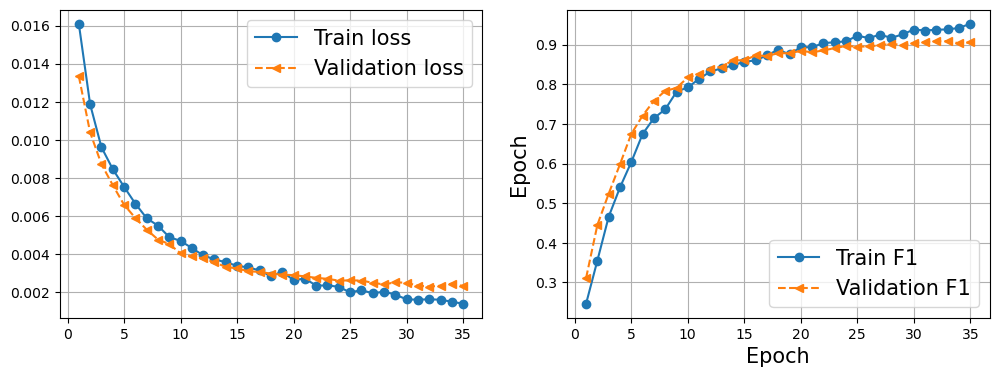

In [22]:
x_axis = np.arange(Config.num_epochs) + 1
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_axis, train_losses, '-o', label = 'Train loss')
ax.plot(x_axis, val_losses, '--<', label = 'Validation loss')
ax.legend(fontsize=15)
ax.grid(True)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_axis, f1_hist_train, '-o', label='Train F1')
ax.plot(x_axis, f1_hist_val, '--<', label='Validation F1')        
ax.legend(fontsize=15)
ax.grid(True)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Epoch', size=15)
plt.show()

## Grade Model (on validation set)

In [23]:
test_ds = CustomImageDataset(val_data_raw, Config.images_path, transform=validation_transforms, use_albumentations=True)
test_dl = DataLoader(
    test_ds, batch_size=Config.batch_size, shuffle=False, num_workers=8, prefetch_factor=8,  
    pin_memory=True, persistent_workers=True
)

criterion = nn.BCEWithLogitsLoss()
actual_labels = []
predicted_labels = []
image_paths = []  # To store paths of processed images
incorrect_predictions = []  # To store (image_path, actual, predicted) for incorrect predictions

f1_test = 0.0
image_idx = 0  # Keep track of position in dataset

with torch.no_grad():
    test_loss = 0.0
    for x, y in tqdm(test_dl):
        batch_size = x.shape[0]
        x, y = x.to(Config.device), y.to(Config.device)
        pred = model(x)
        loss = criterion(pred, y.float())
        test_loss += loss.item()
        pred = torch.sigmoid(pred)
        # Convert to numpy for easier handling
        y_np = to_numpy(y)
        pred_np = to_numpy((pred > 0.5).int())
        
        # Calculate F1 score for this batch
        is_correct = f1_score(pred_np, y_np, average='micro')
        f1_test += is_correct
        
        # Store batch results
        actual_labels.append(y_np)
        predicted_labels.append(pred_np)
        
        # Check each image in the batch for correctness
        for i in range(batch_size):
            # Get the current image's index in the full dataset
            curr_idx = image_idx + i
            if curr_idx < len(test_ds):  # Ensure we don't go out of bounds
                # Get image path from test_data_raw
                img_path = val_data_raw.iloc[curr_idx]['FileName']  # Adjust column name if needed
                
                # Compare prediction with actual label
                if not np.array_equal(pred_np[i], y_np[i]):
                    # This is an incorrect prediction
                    incorrect_predictions.append({
                        'image_path': img_path,
                        'actual': y_np[i],
                        'predicted': pred_np[i]
                    })
        
        # Update image index for next batch
        image_idx += batch_size
        
    f1_test /= np.ceil(len(test_dl.dataset)/Config.batch_size)
print(f'Validation F1: {f1_test}')

100%|██████████| 24/24 [00:01<00:00, 23.32it/s]

Validation F1: 0.9086815994507473


## Where the model is underperforming

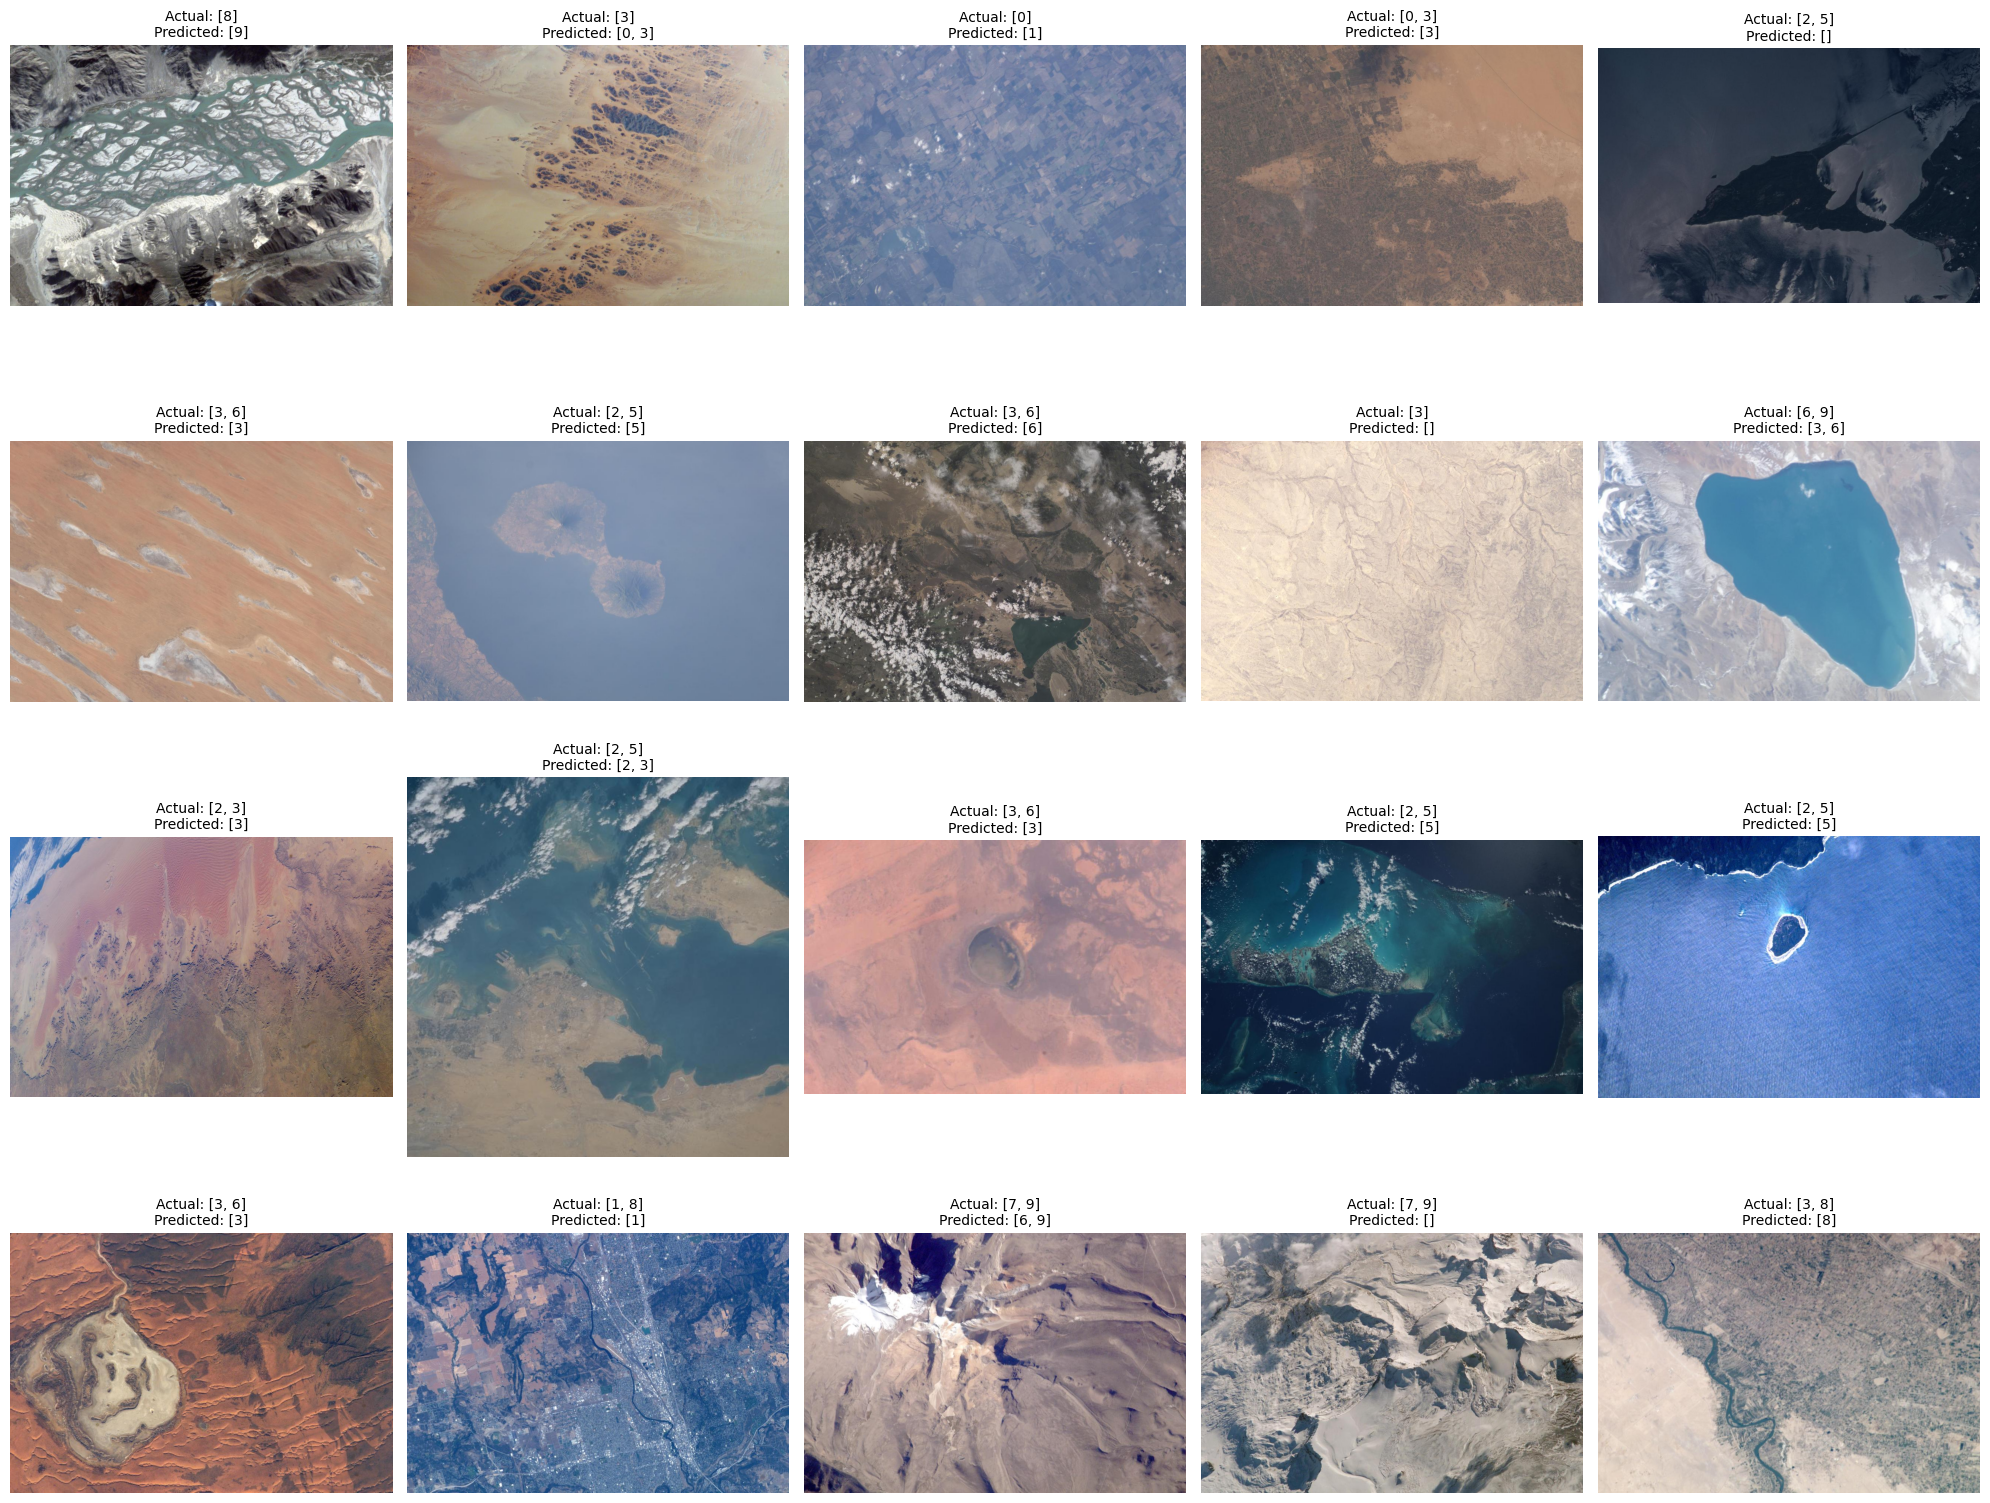

In [24]:
# Now plot the incorrect images
def plot_incorrect_predictions(incorrect_preds, label_names=None, max_images=20):
    """
    Plot images with incorrect predictions
    
    Parameters:
    - incorrect_preds: List of dicts with keys 'image_path', 'actual', 'predicted'
    - label_names: List of label names corresponding to positions in one-hot vector
    - max_images: Maximum number of images to plot
    """
    # Limit number of images to display
    num_to_show = min(max_images, len(incorrect_preds))
    
    # Calculate grid size
    grid_size = int(np.ceil(np.sqrt(num_to_show)))
    
    plt.figure(figsize=(20, 20))
    
    for i in range(num_to_show):
        plt.subplot(grid_size, grid_size, i + 1)
        
        # Load and display image
        img_path = os.path.join(Config.images_path, incorrect_preds[i]['image_path'])
        img = plt.imread(img_path)
        plt.imshow(img)
        
        # Format actual and predicted labels
        actual = incorrect_preds[i]['actual']
        predicted = incorrect_preds[i]['predicted']
        
        if label_names:
            # Convert one-hot encoded vectors to label names
            actual_labels_text = ', '.join([label_names[j] for j, val in enumerate(actual) if val == 1])
            pred_labels_text = ', '.join([label_names[j] for j, val in enumerate(predicted) if val == 1])
            if not actual_labels_text:
                actual_labels_text = "None"
            if not pred_labels_text:
                pred_labels_text = "None"
        else:
            # Display raw vectors
            actual_indices = [j for j, val in enumerate(actual) if val == 1]
            pred_indices = [j for j, val in enumerate(predicted) if val == 1]
            actual_labels_text = f"[{', '.join(map(str, actual_indices))}]"
            pred_labels_text = f"[{', '.join(map(str, pred_indices))}]"
        
        # set title
        plt.title(f"Actual: {actual_labels_text}\nPredicted: {pred_labels_text}", fontsize=10)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Plot incorrect predictions
plot_incorrect_predictions(incorrect_predictions)

## Confusion Matrix

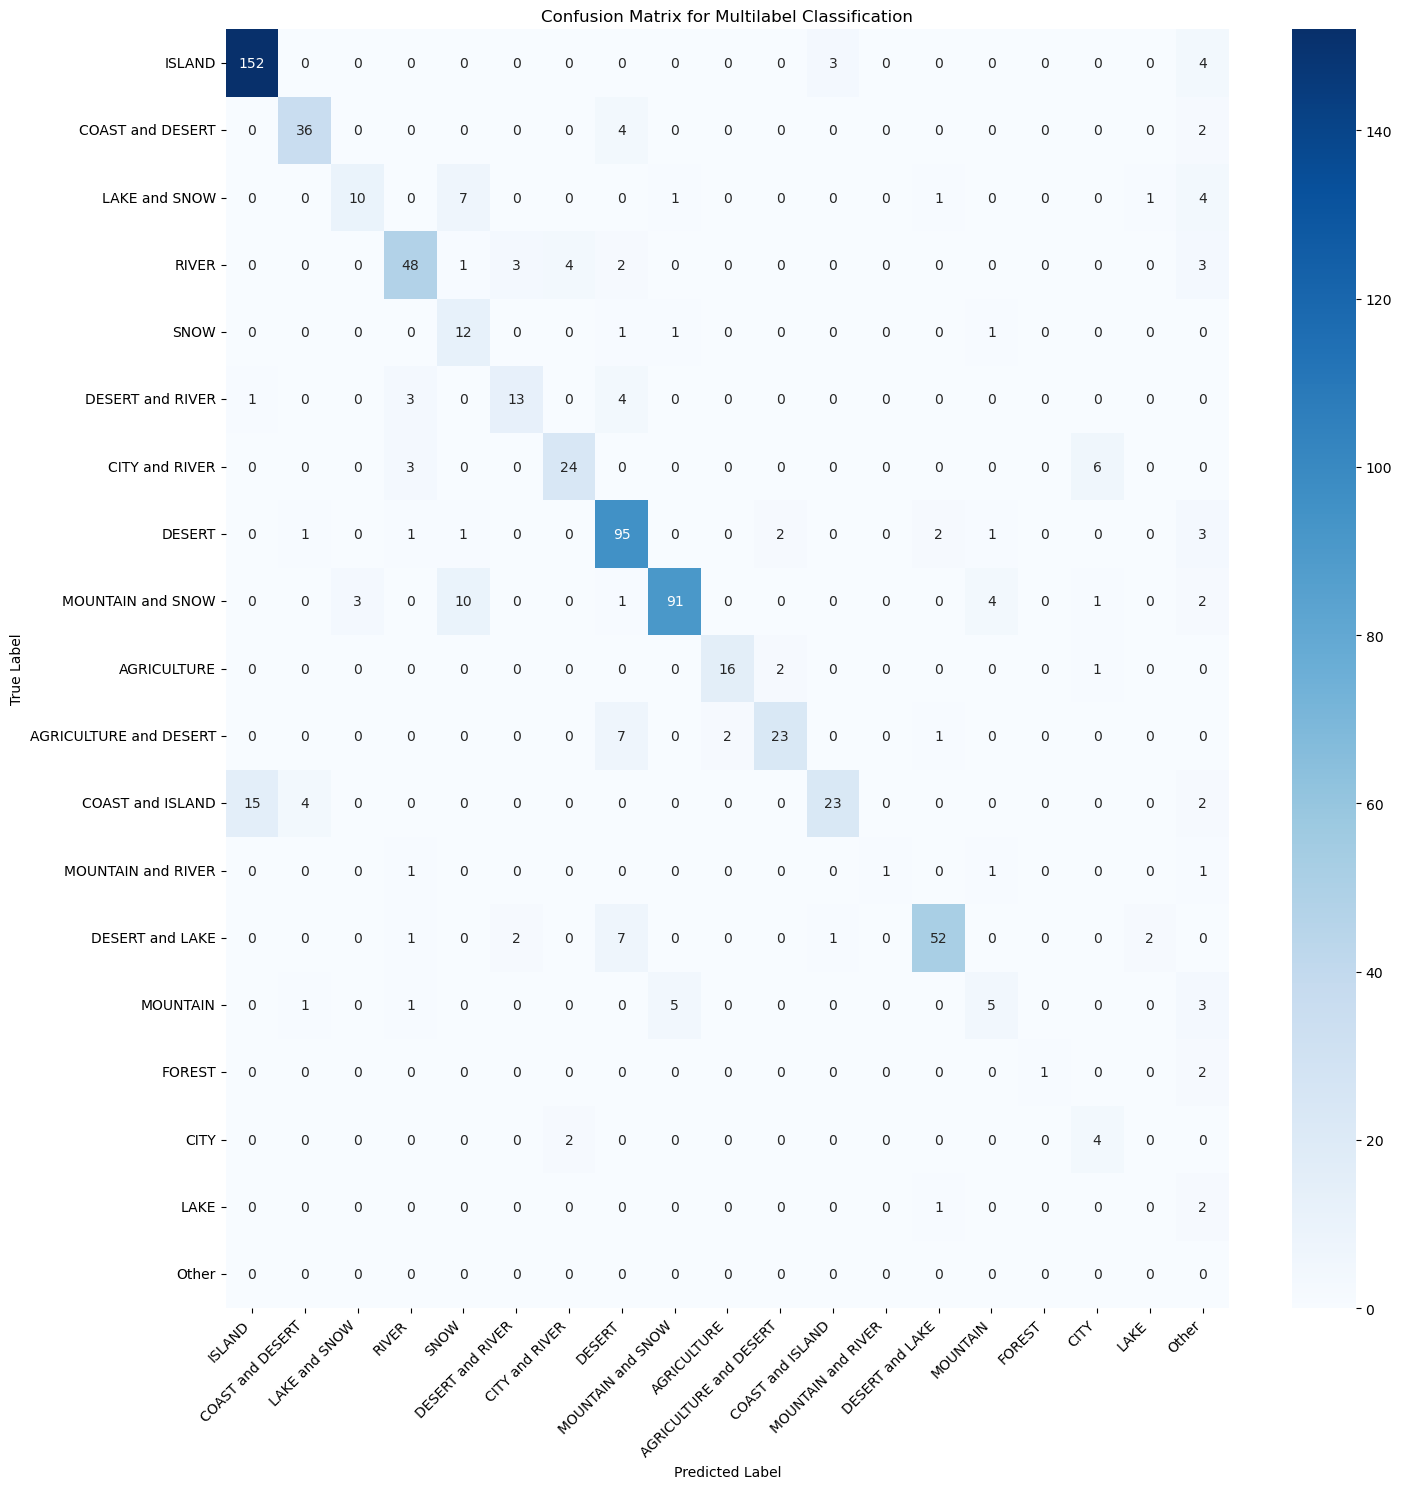

In [25]:
def create_multilabel_confusion_matrix(y_true_arrays, y_pred_arrays, test_data_raw):
    valid_combinations = []
    valid_label_names = {}
    
    # unique label vectors from test data
    for _, row in test_data_raw.drop_duplicates(subset=['Label Vector']).iterrows():
        label_vector = np.array(row['Label Vector'].strip('[]').split(', '), dtype=int)
        if isinstance(label_vector, np.ndarray):
            vector_tuple = tuple(label_vector.flatten())
        else:
            for arr in label_vector:
                if isinstance(arr, np.ndarray):
                    vector_tuple = tuple(arr.flatten())
                    break
                    
        valid_combinations.append(vector_tuple)
        valid_label_names[vector_tuple] = row['Label String']
    
    # add "Other" category
    other_idx = len(valid_combinations)
    
    # convert true and predicted arrays to tuples
    y_true_tuples = []
    y_pred_tuples = []
    
    for array in y_true_arrays:
        for row in array:
            y_true_tuples.append(tuple(row))
            
    for array in y_pred_arrays:
        for row in array:
            y_pred_tuples.append(tuple(row))
    
    # Map each tuple to the index of its class or to "Other"
    def get_class_index(tup):
        if tup in valid_combinations:
            return valid_combinations.index(tup)
        else:
            return other_idx
    
    # convert tuples to class indices
    y_true_indices = [get_class_index(t) for t in y_true_tuples]
    y_pred_indices = [get_class_index(t) for t in y_pred_tuples]
    
    # create labels for the confusion matrix
    labels = [valid_label_names[combo] for combo in valid_combinations] + ["Other"]
    
    # create the confusion matrix
    cm = confusion_matrix(y_true_indices, y_pred_indices, 
                          labels=range(len(valid_combinations) + 1))
    
    # create a DataFrame for better visualization
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    
    return cm, cm_df, labels

def plot_confusion_matrix(cm_df, labels, figsize=(15, 15)):
    # create the plot
    plt.figure(figsize=figsize)
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix for Multilabel Classification')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    return plt.gcf()

cm, cm_df, labels = create_multilabel_confusion_matrix(
    actual_labels, predicted_labels, val_data_raw)
fig = plot_confusion_matrix(cm_df, labels)
plt.show()

# Grading/Submission Guidelines

## Submissions
Please email your submissions to hamzah.abdulrazzaq@lmco.com. All these items must be complete in order for your submission to be considered for evaluation. 
> 1. Email title set to *yourteamname_submission* 
> 2. The python notebook with all your code (.ipynb) 
> 3. Your model checkpoint (.pt) file
> 4. F1 Score copied in with all the digits

**NOTE**: If your email submission is blocked, please try resending the email with a .allow extension added to the file or email title.

Feel free to check out these resources to learn more about evaluation metrics used in Data Science: 
> - https://towardsdatascience.com/how-to-evaluate-machine-learning-model-performance-in-python-135b4ae27f7e 
> - F1 Score: https://towardsdatascience.com/how-to-evaluate-machine-learning-model-performance-in-python-135b4ae27f7e

## Evaluation Process
> - The submission deadline is on Sunday (9/7) 12PM.
> - Presentations will take place on Sunday (9/7) 2PM for the top 3 teams highest performing solutions. Teams will provide a walkthrough of their code. A winner shall be announced thereafter.